##### Copyright 2021 Qiyang Hu

In [ ]:
#@title Licensed under MIT License (the "License");
# You may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://huqy.github.io/learning_sklearn/LICENSE.md
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Prepare the packages

In [1]:
!nvidia-smi

Tue Jul 19 16:39:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Install RAPIDS

In [3]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run cells 1 and 2 only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!pip install pynvml
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/env-check.py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.4 MB/s 
fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
***********************************************************************
Woo! Your instance has the right kind of GPU, a Tesla T4!
***********************************************************************



In [ ]:
# This will update the Colab environment and restart the kernel.
!bash rapidsai-csp-utils/colab/update_gcc.sh
import os
os._exit(00)

Updating your Colab environment.  This will restart your kernel.  Don't Panic!
Hit:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ Packages [85.6 kB]
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://security.ubuntu.com/ubuntu bionic-security/restricted amd64 Packages [1,063 kB]
Hit:13

In [1]:
## Installing CondaColab.  This will restart your kernel again
import condacolab
condacolab.install()

⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:24
🔁 Restarting kernel...


In [1]:
import condacolab
condacolab.check()

✨🍰✨ Everything looks OK!


In [3]:
# Installing RAPIDS is now 'python rapidsai-csp-utils/colab/install_rapids.py <release> <packages>'
# The <release> options are 'stable' and 'nightly'.  Leaving it blank or adding any other words will default to stable.
# The <packages> option are default blank or 'core'.  By default, we install RAPIDSAI and BlazingSQL.  The 'core' option will install only RAPIDSAI and not include BlazingSQL, 
!python rapidsai-csp-utils/colab/install_rapids.py stable
import os
os.environ['NUMBAPRO_NVVM'] = '/usr/local/cuda/nvvm/lib64/libnvvm.so'
os.environ['NUMBAPRO_LIBDEVICE'] = '/usr/local/cuda/nvvm/libdevice/'
os.environ['CONDA_PREFIX'] = '/usr/local'

Found existing installation: cffi 1.15.0
Uninstalling cffi-1.15.0:
  Successfully uninstalled cffi-1.15.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached cffi-1.15.0-cp37-cp37m-manylinux_2_12_x86_64.manylinux2010_x86_64.whl (427 kB)
Installing RAPIDS Stable 21.12
Starting the RAPIDS install on Colab.  This will take about 15 minutes.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with initial frozen solve. Retrying with flexible solve.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
failed with repodata from current_repodata.json, will retry with next repodata source.
Solving environment: ...working... WARNING conda.core.solve:_add_specs(611): pinned spec cudatoolkit=11.1 conflicts with ex

## Install Scikit-Learn-Intelex

In [21]:
!pip install scikit-learn-intelex

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 87 kB 3.6 MB/s 
     |████████████████████████████████| 26.0 MB 1.3 MB/s 
     |████████████████████████████████| 300.3 MB 19 kB/s 
     |████████████████████████████████| 4.0 MB 36.6 MB/s 


# Random Forest Classifier

In [15]:
import cudf
import numpy as np
import pandas as pd
import pickle

from cuml.ensemble import RandomForestClassifier as curfc
from cuml.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier as skrfc
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

from sklearn.metrics import roc_auc_score as sk_auc
from cuml.metrics import roc_auc_score as cuml_auc

## Define Parameters

In [5]:
# The speedup obtained by using cuML'sRandom Forest implementation
# becomes much higher when using larger datasets. Uncomment and use the n_samples
# value provided below to see the difference in the time required to run
# Scikit-learn's vs cuML's implementation with a large dataset.

# n_samples = 2*17
# n_samples = 2**13
n_samples = 2**14
n_features = 399
n_info = 300
data_type = np.float32

## Generate Data

### Host

In [6]:
%%time
X,y = make_classification(n_samples=n_samples,
                          n_features=n_features,
                          n_informative=n_info,
                          random_state=123, n_classes=2)

X = pd.DataFrame(X.astype(data_type))
# cuML Random Forest Classifier requires the labels to be integers
y = pd.Series(y.astype(np.int32))

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=0)

CPU times: user 644 ms, sys: 239 ms, total: 882 ms
Wall time: 667 ms


In [18]:
df = pd.DataFrame({'target': np.random.randint(0, 2, 20000000),
                   'var': np.random.rand(20000000)})

### GPU

In [7]:
%%time
X_cudf_train = cudf.DataFrame.from_pandas(X_train)
X_cudf_test = cudf.DataFrame.from_pandas(X_test)

y_cudf_train = cudf.Series(y_train.values)

CPU times: user 1.86 s, sys: 945 ms, total: 2.8 s
Wall time: 4.2 s


## Scikit-learn Model

In [8]:
%%time
sk_model = skrfc(n_estimators=40,
                 max_depth=16,
                 max_features=1.0,
                 random_state=10)

sk_model.fit(X_train, y_train)

CPU times: user 2min 40s, sys: 0 ns, total: 2min 40s
Wall time: 2min 39s


In [9]:
%%time
sk_predict = sk_model.predict(X_test)
sk_acc = accuracy_score(y_test, sk_predict)

CPU times: user 46.2 ms, sys: 0 ns, total: 46.2 ms
Wall time: 50.9 ms


In [19]:
%%timeit
sk_auc(df['target'], df['var'])

1 loop, best of 5: 11.1 s per loop


## cuML Model

In [11]:
%%time
cuml_model = curfc(n_estimators=40,
                   max_depth=16,
                   max_features=1.0
                   )

cuml_model.fit(X_cudf_train, y_cudf_train)

CPU times: user 4.15 s, sys: 147 ms, total: 4.3 s
Wall time: 3.56 s


In [12]:
%%time
fil_preds_orig = cuml_model.predict(X_cudf_test)

fil_acc_orig = accuracy_score(y_test.to_numpy(), fil_preds_orig)

CPU times: user 450 ms, sys: 59.2 ms, total: 509 ms
Wall time: 477 ms


In [20]:
%%timeit
cuml_auc(df['target'], df['var'])

The slowest run took 19.23 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 5: 330 ms per loop


### Pickle the cuML random forest classification model

In [13]:
filename = 'cuml_random_forest_model.sav'
# save the trained cuml model into a file
pickle.dump(cuml_model, open(filename, 'wb'))
# delete the previous model to ensure that there is no leakage of pointers.
# this is not strictly necessary but just included here for demo purposes.
del cuml_model
# load the previously saved cuml model from a file
pickled_cuml_model = pickle.load(open(filename, 'rb'))

In [14]:
%%time
pred_after_pickling = pickled_cuml_model.predict(X_cudf_test)

fil_acc_after_pickling = accuracy_score(y_test.to_numpy(), pred_after_pickling)

CPU times: user 195 ms, sys: 9.04 ms, total: 204 ms
Wall time: 182 ms


## Scikit-Learn-intelex model

In [22]:
# We have to import scikit-learn AFTER these 2 lines. 
# Otherwise, the patching will not affect the original scikit-learn estimators.
from sklearnex import patch_sklearn
patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [23]:
from sklearn.ensemble import RandomForestClassifier as dalrfc

### Intel CPU optimizations patching

In [24]:
%%time
dal_model = dalrfc(n_estimators=40,
                   max_depth=16,
                   max_features=1.0,
                   random_state=10)

dal_model.fit(X_train, y_train)

CPU times: user 26.7 s, sys: 24.7 ms, total: 26.7 s
Wall time: 26.6 s


In [25]:
%%time
dal_predict = dal_model.predict(X_test)
dal_acc = accuracy_score(y_test, dal_predict)

CPU times: user 35.4 ms, sys: 1.01 ms, total: 36.4 ms
Wall time: 90.7 ms


In [26]:
from sklearn.metrics import roc_auc_score as sk_auc_intel

In [27]:
%%timeit
sk_auc_intel(df['target'], df['var'])

1 loop, best of 5: 3.9 s per loop


### Intel CPU/GPU optimizations patching

No required accelerators available in the google colab session. Thus it cannot experiment the performance for oneDAL. 

Required accelerators for oneDAL:


*   Intel Processor Graphics [GEN9](https://software.intel.com/content/dam/develop/external/us/en/documents/the-compute-architecture-of-intel-processor-graphics-gen9-v1d0-166010.pdf) (and higher)
*   FPGA Cards and FPGA Custom Platforms



## Compare Results

In [ ]:
print("CUML accuracy of the RF model before pickling: %s" % fil_acc_orig)
print("CUML accuracy of the RF model after pickling: %s" % fil_acc_after_pickling)

CUML accuracy of the RF model before pickling: 0.7888312339782715
CUML accuracy of the RF model after pickling: 0.7888312339782715


In [ ]:
print("SKL accuracy: %s" % sk_acc)
print("CUML accuracy before pickling: %s" % fil_acc_orig)
print("oneDAL accuracy: %s" % dal_acc)

SKL accuracy: 0.8104974031448364
CUML accuracy before pickling: 0.7888312339782715
oneDAL accuracy: 0.7958498597145081


| Libraries | Data Loading Time (s) | Training Time (s) | Prediction Time (ms) | roc_auc_score Time (s) for 2^7 data |
| --- | --- | --- | --- | --- |
| Vanilla Scikit-learn | 0.667 | 159 | 50.9 | 11.1 |
| Rapids cuML| 4.2 | 3.56 | 477 | 0.33 |
| Intel sklearnex| 0.667 | 26.6 | 90.7 | 3.9 |

In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
df = pd.DataFrame(
    {'Tasks to test running time': ['DataLoading', 'Training', 'Prediction', 'roc_auc_score'],
     'cuML': [0.667/4.2, 159/3.56, 50.9/477, 11.1/0.33],
     'sklearnex': [1.0, 159/26.6, 50.9/90.7, 11.1/3.9]}
)

Text(0, 0.5, 'Speedup X times')

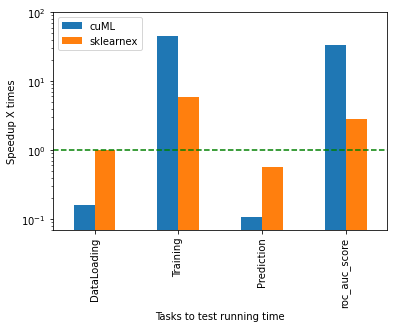

In [8]:
fig, ax = plt.subplots()
df.plot.bar(x='Tasks to test running time', ax=ax, ylim=(0.07,100), logy=True)
plt.axhline(y=1, color='green', linestyle='--')
plt.ylabel('Speedup X times')